<h1 style='color: green; font-size: 36px; font-weight: bold;'>Prediction Rental Prices: Brasilian houses to rent</h1>

## Importando Bibliotecas

In [1]:
# Import das bibliotecas e setting de configurações 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, max_error, make_scorer



import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 400)

%matplotlib inline
plt.rc('figure', figsize = (14, 6))

## Leitura dos dados

Importando o dataset "houses_to_rent_analisado", onde já foi realizado tratamento dos dados:

In [2]:
dataset = pd.read_csv('datasets/houses_to_rent_analisado.csv', sep=',')

Detalhando algumas informações através do metodo info:

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10660 entries, 0 to 10659
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   city            10660 non-null  object
 1   area            10660 non-null  int64 
 2   rooms           10660 non-null  int64 
 3   bathroom        10660 non-null  int64 
 4   parking spaces  10660 non-null  int64 
 5   floor           10660 non-null  int64 
 6   animal          10660 non-null  int64 
 7   furniture       10660 non-null  int64 
 8   hoa             10660 non-null  int64 
 9   rent amount     10660 non-null  int64 
 10  property tax    10660 non-null  int64 
 11  fire insurance  10660 non-null  int64 
 12  total           10660 non-null  int64 
dtypes: int64(12), object(1)
memory usage: 1.1+ MB


## Matriz de Correlação

<AxesSubplot:>

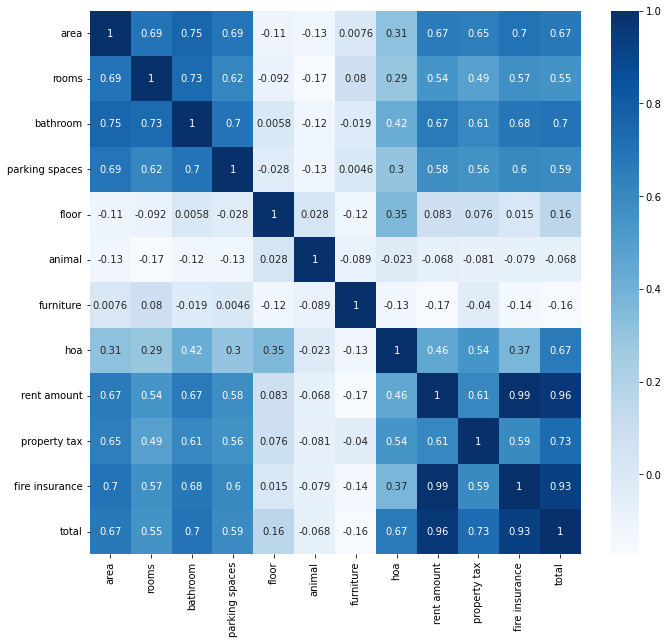

In [4]:
corr = dataset.drop(['city'], axis=1).corr()

plt.figure(figsize=(11,10))

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap="Blues", annot=True)

A coluna 'total'(valor total de aluguel), é formado a partir da soma de quatro outras colunas ('hoa', 'rend amount', 'property tax', 'fire insurance'). Então, como estamos querendo prever os valores dos imoveis, não teriamos este tipo informações, logo não utiliizaremos estas colunas por esses dois motivos.

Retirando as colunas que não serão utilizadas:

In [5]:
dataset.loc[:,['area', 'rooms', 'bathroom', 'parking spaces', 'floor','animal', 'furniture', 'total']].corr().round(4)

,area,rooms,bathroom,parking spaces,floor,animal,furniture,total
area,1.0000,0.6938,0.7543,0.6897,-0.1105,-0.1303,0.0076,0.6732
rooms,0.6938,1.0000,0.7341,0.6165,-0.0923,-0.1726,0.0805,0.5525
bathroom,0.7543,0.7341,1.0000,0.6975,0.0058,-0.1201,-0.0186,0.6976
parking spaces,0.6897,0.6165,0.6975,1.0000,-0.0280,-0.1288,0.0046,0.5901
floor,-0.1105,-0.0923,0.0058,-0.0280,1.0000,0.0279,-0.1244,0.1615
animal,-0.1303,-0.1726,-0.1201,-0.1288,0.0279,1.0000,-0.0889,-0.0681
furniture,0.0076,0.0805,-0.0186,0.0046,-0.1244,-0.0889,1.0000,-0.1648
total,0.6732,0.5525,0.6976,0.5901,0.1615,-0.0681,-0.1648,1.0000


## Variável Dependente X Variáveis Explicativas

Utilizaremos o gráfico de dispersão entre as variáveis do dataset para ter uma visualização gráfica do comportamento variável independentes sobre a variável dependente

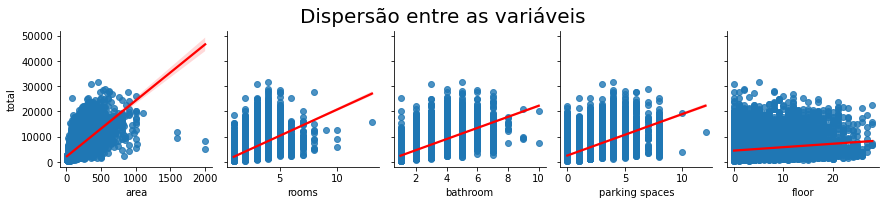

In [6]:
ax = sns.pairplot(dataset.loc[:,['area', 'rooms', 'bathroom', 'parking spaces', 'floor', 'total']],
                     y_vars='total', 
                     x_vars=['area', 'rooms', 'bathroom', 'parking spaces', 'floor'],
                     kind='reg', 
                     plot_kws={'line_kws':{'color':'red'}})
ax.fig.suptitle("Dispersão entre as variáveis", fontsize=20, y=1.1) # o argumento y indica a posição do titulo em relação ao eixo y
plt.show()

Através do gráfico é possível perceber que todas as variáveis independentes possui uma tendência positiva.  A 'area' possui uma tendência mais próxima de ser uma relação linear em relação as outras, já que seus dados são menos dispersos.

## Codificação categórica (OneHotEncoder)

A feature 'city' é uma variável categórica, logo, não pode ser utilizada como feature para criação de um modelo de Machine Learning. Para poder utilizar esta feature vai ser aplicado a One-hot encoding.

In [7]:
encoder = ce.OneHotEncoder(use_cat_names=True)
df_encoded = encoder.fit_transform(dataset[['city']])
df_encoded.head()

,city_São Paulo,city_Porto Alegre,city_Rio de Janeiro,city_Campinas,city_Belo Horizonte
0,1,0,0,0,0
1,1,0,0,0,0
2,0,1,0,0,0
3,0,1,0,0,0
4,1,0,0,0,0


Concatenando o dataset das cidades com o cojunto de dados e dropando a feature 'city':

In [8]:
dataset = dataset.drop('city',axis=1)
dataset = pd.concat([dataset, df_encoded], axis=1)
dataset.head()

,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa,rent amount,property tax,fire insurance,total,city_São Paulo,city_Porto Alegre,city_Rio de Janeiro,city_Campinas,city_Belo Horizonte
0,70,2,1,1,7,0,0,2065,3300,211,42,5618,1,0,0,0,0
1,320,4,4,0,20,0,1,1200,4960,1750,63,7973,1,0,0,0,0
2,80,1,1,1,6,0,1,1000,2800,0,41,3841,0,1,0,0,0
3,51,2,1,0,2,0,1,270,1112,22,17,1421,0,1,0,0,0
4,25,1,1,0,1,1,1,0,800,25,11,836,1,0,0,0,0


## Padronização do Conjunto de Dados

In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10660 entries, 0 to 10659
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   area                 10660 non-null  int64
 1   rooms                10660 non-null  int64
 2   bathroom             10660 non-null  int64
 3   parking spaces       10660 non-null  int64
 4   floor                10660 non-null  int64
 5   animal               10660 non-null  int64
 6   furniture            10660 non-null  int64
 7   hoa                  10660 non-null  int64
 8   rent amount          10660 non-null  int64
 9   property tax         10660 non-null  int64
 10  fire insurance       10660 non-null  int64
 11  total                10660 non-null  int64
 12  city_São Paulo       10660 non-null  int64
 13  city_Porto Alegre    10660 non-null  int64
 14  city_Rio de Janeiro  10660 non-null  int64
 15  city_Campinas        10660 non-null  int64
 16  city_Belo Horizonte  1

In [10]:
features = dataset.loc[:,['area', 'rooms', 'bathroom', 'parking spaces', 'floor', 'animal', 'furniture', 'city_São Paulo', 'city_Porto Alegre', 'city_Rio de Janeiro', 'city_Campinas', 'city_Belo Horizonte']]
features_list = list(features.columns)

Sendo os dados de ordens de magnitude diferente, iremos normalizar todo o conjunto de dados para evitar que algumas features dominem a função objetivo e atrapalhe o estimador.

In [11]:
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaler.fit(features)
features_norm = scaler.transform(features)

In [12]:
df_features_norm = pd.DataFrame(features_norm, columns=features_list)
df_features_norm.head()

,area,rooms,bathroom,parking spaces,floor,animal,furniture,city_São Paulo,city_Porto Alegre,city_Rio de Janeiro,city_Campinas,city_Belo Horizonte
0,0.029663,0.083333,0.000000,0.083333,0.250000,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.155354,0.250000,0.333333,0.000000,0.714286,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.034691,0.000000,0.000000,0.083333,0.214286,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.020111,0.083333,0.000000,0.000000,0.071429,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.007039,0.000000,0.000000,0.000000,0.035714,1.0,1.0,1.0,0.0,0.0,0.0,0.0


## Recalculando a correlação

<AxesSubplot:>

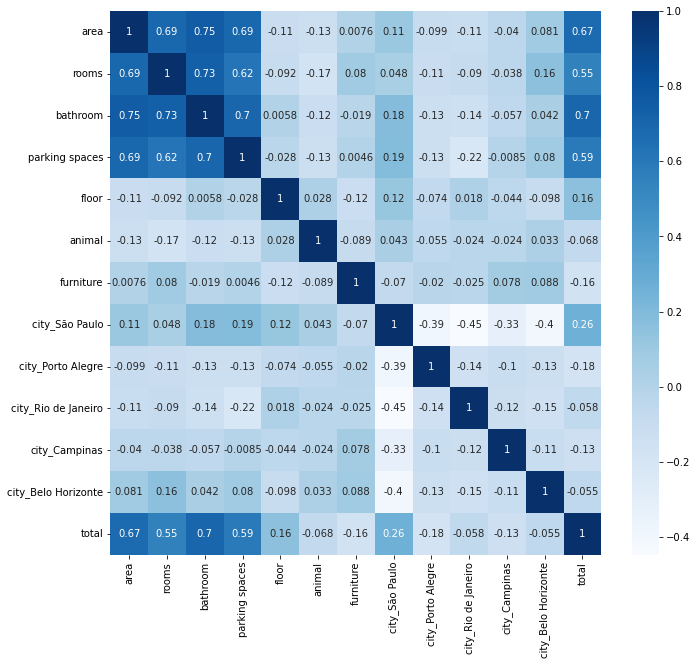

In [13]:
df_features_norm['total'] = dataset['total']
corr = df_features_norm.corr()

plt.figure(figsize=(11,10))

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap="Blues", annot=True)

## Métricas

Para avaliar os modelos serão utilizados as seguintes métricas:

- Coeficiente de Determinação (r2_score): Representa a proporção da variância (de y) que foi explicada pelas variáveis ​​independentes no modelo. Ela fornece uma indicação da qualidade do ajuste e, portanto, uma medida de quão bem as amostras não vistas provavelmente serão previstas pelo modelo, por meio da proporção da variância explicada. Se
$\hat{y}_i$ é o valor previsto da iª amostra e ${y}$ é o valor verdadeiro correspondente para o totala $n$ mostras, a estimativa $R^2$ é definido como:

$$R^2(y, \hat{y}) = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1} ^{n} (y_i - \bar{y})^2}$$

onde $\bar{y} = \frac{1}{n} \sum_{i=1}^{n} y_i$

- Erro Quadrático Médio (mean_squared_error): é definido como sendo a média da diferença entre o valor do estimador e do parâmetro ao quadrado. MSE é uma métrica de risco correspondente ao valor esperado do erro ou perda (quadrática). Por conta do expoente ao quadrado que o erro assume, essa métrica é bastante sensível a outliers (valores discrepantes) e, caso tenha muitos erros significativos em sua análise, essa métrica poderá ser extrapolada. Se $\hat{y}_i$ é o valor previsto do iª amostra, ${y}$ é o valor verdadeiro correspondente, então o erro quadrático médio (MSE) estimado sobre $n_\text{amostras}$ é definido como

$$\text{MSE}(y, \hat{y}) = \frac{1}{n_\text{amostras}} \sum_{i=0}^{n_\text{amostras} - 1} (y_i - \hat{y}_i)^2$$

- Raiz Quadrada do Erro Médio (RMSE): A raiz quadrada do erro médio, RMSE (da sigla em inglês Root Mean Squared Error) é apenas a raiz quadrada do MSE, onde o erro retorna à unidade de medida do modelo (no MSE, a unidade de medida é quadrática). É frequentemente por ser mais sensível a erros maiores devido ao processo de quadratura que a produziu.

$$\text{RMSE}(y, \hat{y}) = \sqrt {\frac{1}{n_\text{amostras}} \sum_{i=0}^{n_\text{amostras} - 1} (y_i - \hat{y}_i)^2}$$

- Máximo erro (max_error): é função calcula o erro residual máximo, uma métrica que captura o erro de pior caso entre o valor previsto e o valor verdadeiro. Em um modelo de regressão de saída única perfeitamente ajustado, max_errorestaria 0 no conjunto de treinamento e, embora isso fosse altamente improvável no mundo real, essa métrica mostra a extensão do erro que o modelo tinha quando foi ajustado.

$$ \text{Max Error}(y, \hat{y}) = \max(| y_i - \hat{y}_i |) $$

In [25]:
def create_model(X, y, model, index_name, return_model=False):
    scoring = {'r2_score': make_scorer(r2_score),
                'mean_squared_error': make_scorer(mean_squared_error),
                'RMSE': make_scorer(mean_squared_error),
                'max_error': make_scorer(max_error)
                }
    
    cv = cross_validate(estimator=model, X=X, y=y, cv=10, return_train_score=True, scoring=scoring, n_jobs=-1, return_estimator=return_model)
    
    series_scoring = pd.Series({'mean_squared_error_train': cv['train_mean_squared_error'].mean(),
                   'mean_squared_error_test': cv['test_mean_squared_error'].mean(),
                   'RMSE_train': np.sqrt(cv['train_RMSE'].mean()),
                   'RMSE_test': np.sqrt(cv['test_RMSE'].mean()),
                   'r2_score_train': cv['train_r2_score'].mean(),
                   'r2_score_test': cv['test_r2_score'].mean(),
                   'max_error_train': cv['train_max_error'].mean(),
                   'max_error_test': cv['test_max_error'].mean(),
                  },name=index_name)

    if return_model == True:
        return series_scoring, cv
    else:
        return series_scoring

metrics=pd.DataFrame()

## Regressão Linear (LinearRegression)

In [26]:
X = features_norm
y = dataset['total']

In [27]:
linear_regression = LinearRegression()
metrics = metrics.append(create_model(X, y, linear_regression, 'LinearRegression'))
metrics

,mean_squared_error_train,mean_squared_error_test,RMSE_train,RMSE_test,r2_score_train,r2_score_test,max_error_train,max_error_test
LinearRegression,7.334029e+06,7.361790e+06,2708.141186,2713.261897,0.624464,0.622867,22753.125,18020.3


## Decision Tree Regressor (DecisionTreeRegressor)

In [28]:
d_tree = DecisionTreeRegressor(random_state=42)
metrics = metrics.append(create_model(X, y, d_tree, 'DecisionTreeRegressor'))
metrics

,mean_squared_error_train,mean_squared_error_test,RMSE_train,RMSE_test,r2_score_train,r2_score_test,max_error_train,max_error_test
LinearRegression,7.334029e+06,7.361790e+06,2708.141186,2713.261897,0.624464,0.622867,22753.125,18020.30
DecisionTreeRegressor,1.426006e+05,1.168568e+07,377.624912,3418.431731,0.992699,0.400528,7178.175,18340.25


## Random Forest Regressor (RandomForestRegressor)

In [29]:
rnd_frst = RandomForestRegressor(random_state=42)
metrics = metrics.append(create_model(X, y, d_tree, 'RandomForestRegressor'))
metrics

,mean_squared_error_train,mean_squared_error_test,RMSE_train,RMSE_test,r2_score_train,r2_score_test,max_error_train,max_error_test
LinearRegression,7.334029e+06,7.361790e+06,2708.141186,2713.261897,0.624464,0.622867,22753.125,18020.30
DecisionTreeRegressor,1.426006e+05,1.168568e+07,377.624912,3418.431731,0.992699,0.400528,7178.175,18340.25
RandomForestRegressor,1.426006e+05,1.168568e+07,377.624912,3418.431731,0.992699,0.400528,7178.175,18340.25


## XGBRegressor

XGBoost é uma biblioteca otimizada de aumento de gradiente distribuída projetada para ser altamente eficiente, flexível e portátil. Ele implementa algoritmos de aprendizado de máquina sob a estrutura Gradient Boosting. O XGBoost fornece um reforço de árvore paralela (também conhecido como GBDT, GBM) que resolve muitos problemas de ciência de dados de maneira rápida e precisa.

Gradient Boosting fornece um modelo de previsão na forma de um conjunto de modelos de previsão fracos, que normalmente são árvores de decisão. Quando uma árvore de decisão é o aprendiz fraco, o algoritmo resultante é chamado de árvores impulsionadas por gradiente; geralmente supera a floresta aleatória . Um modelo de árvores impulsionado por gradiente é construído de maneira faseada como em outros métodos de impulsionamento, mas generaliza os outros métodos permitindo a otimização de um função de perda diferenciável.

Fonte: https://xgboost.readthedocs.io/en/stable/index.html

In [30]:
xgb = XGBRegressor(base_score=0.5, verbose=False)
metrics = metrics.append(create_model(X, y, xgb, 'XGBRegressor'))
metrics

,mean_squared_error_train,mean_squared_error_test,RMSE_train,RMSE_test,r2_score_train,r2_score_test,max_error_train,max_error_test
LinearRegression,7.334029e+06,7.361790e+06,2708.141186,2713.261897,0.624464,0.622867,22753.12500,18020.300000
DecisionTreeRegressor,1.426006e+05,1.168568e+07,377.624912,3418.431731,0.992699,0.400528,7178.17500,18340.250000
RandomForestRegressor,1.426006e+05,1.168568e+07,377.624912,3418.431731,0.992699,0.400528,7178.17500,18340.250000
XGBRegressor,2.655573e+06,6.388211e+06,1629.592848,2527.491132,0.864018,0.672682,20856.74541,15702.860132


## CatBoostRegressor

O CatBoost é um nova tecinica de aumento de gradiente. O CatBoost a superar outras implementações de aprimoramento disponíveis publicamente em termos de qualidade em uma variedade de conjuntos de dados. Dois avanços algorítmicos críticos introduzidos no CatBoost são a implementação de reforço ordenado, uma alternativa orientada por permutação ao algoritmo clássico e um algoritmo inovador para processar recursos categóricos. Ambas as técnicas foram criadas para combater uma mudança de previsão causada por um tipo especial de vazamento de alvo presente em todas as implementações atualmente existentes de algoritmos de aumento de gradiente.

Fonte: https://catboost.ai/en/docs/

In [31]:
catboost_model = CatBoostRegressor(verbose=False, random_seed=42)
series_scoring, model = create_model(X, y, catboost_model, 'CatBoostRegressor', True)
metrics = metrics.append(series_scoring)
metrics

,mean_squared_error_train,mean_squared_error_test,RMSE_train,RMSE_test,r2_score_train,r2_score_test,max_error_train,max_error_test
LinearRegression,7.334029e+06,7.361790e+06,2708.141186,2713.261897,0.624464,0.622867,22753.125000,18020.300000
DecisionTreeRegressor,1.426006e+05,1.168568e+07,377.624912,3418.431731,0.992699,0.400528,7178.175000,18340.250000
RandomForestRegressor,1.426006e+05,1.168568e+07,377.624912,3418.431731,0.992699,0.400528,7178.175000,18340.250000
XGBRegressor,2.655573e+06,6.388211e+06,1629.592848,2527.491132,0.864018,0.672682,20856.745410,15702.860132
CatBoostRegressor,3.757278e+06,5.880102e+06,1938.370000,2424.892254,0.807612,0.699047,21819.875516,14879.645125


## Otimizando os hiperparâmetros do CatBoostRegressor

In [34]:
X = features_norm
y = dataset['total']

X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.20, random_state=42)

model = CatBoostRegressor()

grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

grid_search_result = model.grid_search(grid,
                                       X=X_train,
                                       y=y_train,
                                       cv = KFold(n_splits = 3, shuffle=True),
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 6629.7756554	test: 6423.6743171	best: 6423.6743171 (0)	total: 133ms	remaining: 2m 13s
1:	learn: 6474.2203500	test: 6271.4441068	best: 6271.4441068 (1)	total: 140ms	remaining: 1m 9s
2:	learn: 6324.4459195	test: 6126.4631004	best: 6126.4631004 (2)	total: 146ms	remaining: 48.5s
3:	learn: 6177.9794253	test: 5984.0882648	best: 5984.0882648 (3)	total: 148ms	remaining: 36.9s
4:	learn: 6040.6137312	test: 5848.6474580	best: 5848.6474580 (4)	total: 151ms	remaining: 30s
5:	learn: 5903.3222396	test: 5715.3097200	best: 5715.3097200 (5)	total: 154ms	remaining: 25.6s
6:	learn: 5772.7704075	test: 5587.6339019	best: 5587.6339019 (6)	total: 158ms	remaining: 22.4s
7:	learn: 5648.2164126	test: 5465.1828318	best: 5465.1828318 (7)	total: 161ms	remaining: 20s
8:	learn: 5525.9866837	test: 5345.1660289	best: 5345.1660289 (8)	total: 164ms	remaining: 18.1s
9:	learn: 5409.2430953	test: 5231.8740787	best: 5231.8740787 (9)	total: 166ms	remaining: 16.5s
10:	learn: 5297.1670920	test: 5120.3514140	best: 5120

In [37]:
grid_search_result['params']

{'depth': 6, 'l2_leaf_reg': 1, 'learning_rate': 0.03}

## Conclusão

Dentre os modelos de regressão abortados, o que obteve melhor resultado foi O CatBoostRegressor com RMSE de R$2430.58 e pontuação do Coeficiente de Determinação igual 0.70 para os dados de teste. No entanto, note que a pontuação no conjunto de treinamento ainda é muito menor do que nos conjuntos de validação, o que significa que o modelo está se sobreajustando ao conjunto de treinamento. As métricas mean_squared_error e RMSE são métricas que são sensíveis a outliers (valores discrepantes), logo é possível perceber a ocorrência de muitos erros significativos na análise, já que as duas métricas foram extrapoladas. 

Para uma abordagem mais eficiente, no entanto, é necessário considerar um número maior de features. Uma feature de extrema importância é a localização geográfica do imóvel na cidade, já que é uma feature que independem das características físicas e causam grande impacto sobre o valor final do aluguel. Imóveis localizados em bairros mais próximos a periferia das cidades vão possuir um valor de aluguel por metro quadrado de área mais barato do que os imóveis que são localizados no centro.